In [3]:
### I disabled my GPU since most of you will not have that
import os
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"   # see issue #152
os.environ["CUDA_VISIBLE_DEVICES"] = ""

## DavisSML Tensorflow Lab 2

Some content is taken from 
- www.tensorflow.org 
- http://rail.eecs.berkeley.edu/deeprlcourse/

To install tensorflow and keras use pip:
`pip install tensorflow`, `pip install keras`

### Keras

- high level API, typically do not interact with Tensors as in base tensorflow
- build Models from Layers
- integrated with Datasets API
- extensible : can build custom layers

In [4]:
from __future__ import print_function
import keras
from keras import layers, datasets, models
from keras import backend as K
import tensorflow as tf
import matplotlib.pyplot as plt

### Models and Layers

- Models contain Layers (in a graph)
- Layers contain all of the tensors, variables, operations, etc.
- Sequential graph is just a stack of layers (one feeds into the next)

In [3]:
model = keras.Sequential()
# Adds a densely-connected layer with 64 units to the model:
model.add(layers.Dense(64, activation='relu'))
# Add another:
model.add(layers.Dense(64, activation='relu'))
# Add a softmax layer with 10 output units:
model.add(layers.Dense(10, activation='softmax'))

See the layers that are in the model here:

In [4]:
model.layers

Layers have 
- activation parameter: can be `tf.sigmoid` or 'sigmoid' for example
- kernel initializer, bias initializer: how to initialize coefficients or intercept
- kernel_regularizer, bias_regularizer: regularizers for coefficients and intercepts

In [5]:
model = keras.Sequential()
# Adds a densely-connected layer with 64 units to the model:
model.add(layers.Dense(64, activation=tf.sigmoid,kernel_initializer='orthogonal')) # random orthogonal matrix init
# Add another:
model.add(layers.Dense(64, activation='relu',kernel_regularizer = keras.regularizers.l1(0.01))) # l1 regularizer
# Add a softmax layer with 10 output units:
model.add(layers.Dense(10, activation='softmax'))

Model compile:
- optimizer: ex. tf.train.AdamOptimizer, tf.train.RMSPropOptimizer, tf.train.GradientDescentOptimizer
- loss: mse, categorical_crossentropy, and binary_crossentropy
- metrics: monitoring training

Documentation: [Losses](https://keras.io/losses/), [Metrics](https://keras.io/metrics/), [Optimizers](https://www.tensorflow.org/api_docs/python/tf/keras/optimizers)

In [6]:
model.compile(optimizer=tf.train.AdamOptimizer(0.001),
              loss='categorical_crossentropy', 
              # if you have 10 classes, the target for each sample should be a 10-dimensional vector that is all-zeros except for a 1 at the index corresponding to the class of the sample
              metrics=['accuracy'])

Instructions for updating:
Colocations handled automatically by placer.


Model fit will run the optimizer with epochs, batch_size, validation_data 

In [7]:
import numpy as np

data = np.random.random((1000, 32))
labels = np.random.random((1000, 10))

model.fit(data, labels, epochs=10, batch_size=32)

Instructions for updating:
Use tf.cast instead.
Epoch 1/10
1000/1000 [==============================] - 0s 356us/step - loss: 15.4522 - acc: 0.1060
Epoch 2/10
1000/1000 [==============================] - 0s 45us/step - loss: 14.4949 - acc: 0.0940
Epoch 3/10
1000/1000 [==============================] - 0s 39us/step - loss: 13.6724 - acc: 0.0910
Epoch 4/10
1000/1000 [==============================] - 0s 42us/step - loss: 12.9883 - acc: 0.0960
Epoch 5/10
1000/1000 [==============================] - 0s 39us/step - loss: 12.4492 - acc: 0.0940
Epoch 6/10
1000/1000 [==============================] - 0s 42us/step - loss: 12.0463 - acc: 0.0900
Epoch 7/10
1000/1000 [==============================] - 0s 38us/step - loss: 11.7777 - acc: 0.0910
Epoch 8/10
1000/1000 [==============================] - 0s 42us/step - loss: 11.6293 - acc: 0.0950
Epoch 9/10
1000/1000 [==============================] - 0s 41us/step - loss: 11.5454 - acc: 0.0940
Epoch 10/10
1000/1000 [==============================] - 0s 

### Custom layer
- build: Create the weights of the layer. Add weights with the add_weight method.
- call: Define the forward pass.
- compute_output_shape: Specify how to compute the output shape of the layer given the input shape.

In [8]:
for l in model.layers:
    print("{} : {} to {}".format(l.name,l.input_shape,l.output_shape))

dense_1 : (None, 32) to (None, 64)
dense_2 : (None, 64) to (None, 64)
dense_3 : (None, 64) to (None, 10)


In [9]:
class MyLayer(layers.Layer):

  def __init__(self, output_dim, **kwargs):
    self.output_dim = output_dim #output dimension
    super(MyLayer, self).__init__(**kwargs)

  def build(self, input_shape):
    shape = tf.TensorShape((input_shape[1], self.output_dim)) #input_shape[1] the number of features
    # Create a trainable weight variable for this layer.
    self.kernel = self.add_weight(name='kernel',
                                  shape=shape,
                                  initializer='uniform',
                                  trainable=True)
    # Make sure to call the `build` method at the end
    super(MyLayer, self).build(input_shape)

  def call(self, inputs):
    return tf.matmul(inputs, self.kernel)

  def compute_output_shape(self, input_shape):
    shape = tf.TensorShape(input_shape).as_list()
    shape[-1] = self.output_dim
    return tf.TensorShape(shape)

### Image data

We will create a model that includes
- convolutional layers: convolution of a kernel of certain size, number of channels, activation
- pooling: max pooling for example, pool size
- dropout: dropout probability

In [34]:
batch_size = 128
num_classes = 10
epochs = 4

# input image dimensions
img_rows, img_cols = 28, 28

In [35]:
# the data, split between train and test sets
(x_train, y_train), (x_test, y_test) = datasets.mnist.load_data()
# MNIST dataset contains greyscale 10 digit imges, with 60000 train samples and 10000 test samples
if K.image_data_format() == 'channels_first':
    x_train = x_train.reshape(x_train.shape[0], 1, img_rows, img_cols) # 4 dimension tensor, 1 represents there is only 1 channel.
    x_test = x_test.reshape(x_test.shape[0], 1, img_rows, img_cols)
    input_shape = (1, img_rows, img_cols)
else:
    x_train = x_train.reshape(x_train.shape[0], img_rows, img_cols, 1)
    x_test = x_test.reshape(x_test.shape[0], img_rows, img_cols, 1)
    input_shape = (img_rows, img_cols, 1)

In [36]:
x_train.shape

(60000, 28, 28, 1)

In [37]:
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255
print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

x_train shape: (60000, 28, 28, 1)
60000 train samples
10000 test samples


In [38]:
y_train.dtype

dtype('uint8')

In [39]:
# convert class vectors to binary class matrices
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)
# initially, the response variable is 'unit8' data type, which is not categorically, we need to transform

model = keras.Sequential()
model.add(layers.Conv2D(32, kernel_size=(3, 3),
                 activation='relu',
                 input_shape=input_shape))
#kernel_size:specifying the height and width of the 2D convolution window. 
# 32 is the number of the filters
#data_format:channels_last corresponds to inputs with shape (batch, height, width, channels) 
#        while channels_first corresponds to inputs with shape (batch, channels, height, width)
# default strides is (1,1)
# The output should be 26*26 of each filter, and the number of the filter is 32

model.add(layers.MaxPooling2D(pool_size=(2, 2))) # the output should be 13*13, with 32 filter?
#Pooling can be max or average, here we use max
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D(pool_size=(2, 2)))

model.add(layers.Dropout(0.25))
model.add(layers.Flatten())
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dropout(0.5)) # float between 0 and 1. Fraction of the input units to drop
model.add(layers.Dense(num_classes, activation='softmax'))

In [40]:
for l in model.layers:
    print("{} : {} to {}".format(l.name,l.input_shape,l.output_shape))

conv2d_9 : (None, 28, 28, 1) to (None, 26, 26, 32)
max_pooling2d_8 : (None, 26, 26, 32) to (None, 13, 13, 32)
conv2d_10 : (None, 13, 13, 32) to (None, 11, 11, 64)
max_pooling2d_9 : (None, 11, 11, 64) to (None, 5, 5, 64)
dropout_6 : (None, 5, 5, 64) to (None, 5, 5, 64)
flatten_5 : (None, 5, 5, 64) to (None, 1600)
dense_12 : (None, 1600) to (None, 128)
dropout_7 : (None, 128) to (None, 128)
dense_13 : (None, 128) to (None, 10)


In [41]:
model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.Adadelta(),
              metrics=['accuracy'])

model.fit(x_train, y_train,
          batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          validation_data=(x_test, y_test))
# Verbosity mode. 0 = silent, 1 = progress bar, 2 = one line per epoch.
# Data on which to evaluate the loss and any model metrics at the end of each epoch.
#     The model will not be trained on validation_data.
score = model.evaluate(x_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Train on 60000 samples, validate on 10000 samples
Epoch 1/4
60000/60000 [==============================] - 35s 580us/step - loss: 0.3116 - acc: 0.9026 - val_loss: 0.0655 - val_acc: 0.9785
Epoch 2/4
60000/60000 [==============================] - 33s 543us/step - loss: 0.1064 - acc: 0.9679 - val_loss: 0.0463 - val_acc: 0.9840
Epoch 3/4
60000/60000 [==============================] - 32s 533us/step - loss: 0.0825 - acc: 0.9755 - val_loss: 0.0358 - val_acc: 0.9881
Epoch 4/4
60000/60000 [==============================] - 36s 607us/step - loss: 0.0676 - acc: 0.9793 - val_loss: 0.0332 - val_acc: 0.9889
Test loss: 0.03321283216568408
Test accuracy: 0.9889


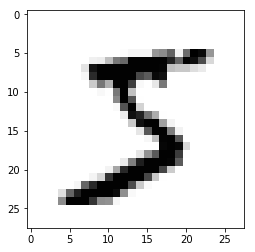

In [18]:
plt.imshow(x_train[0,...,0],cmap='Greys')

In [54]:
layer_outputs = [layer.output for layer in model.layers[:4]]  #the first 4 layers of model
activation_model = models.Model(inputs=model.input, outputs=layer_outputs) 
# Creates a model that will return these outputs, given the model input
# will give the outputs of the 4 layers?

In [56]:
activations = activation_model.predict(x_train[[0],...]) 
# Returns a list of 4 Numpy arrays: one array per layer activation

In [64]:
activations[0].shape

(1, 26, 26, 32)

/home/jsharpna/anaconda/lib/python3.7/site-packages/ipykernel_launcher.py:18: RuntimeWarning: invalid value encountered in true_divide


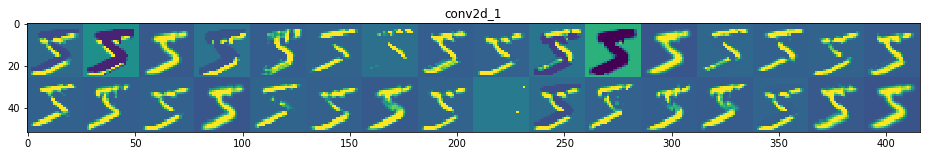

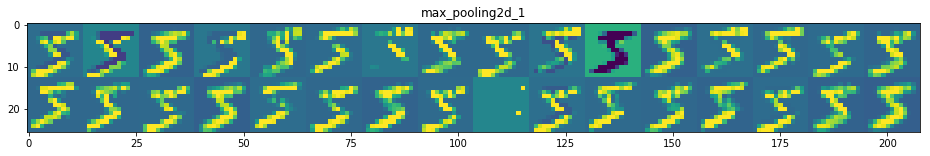

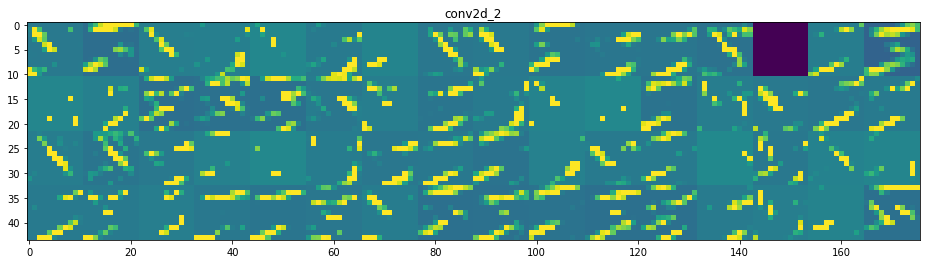

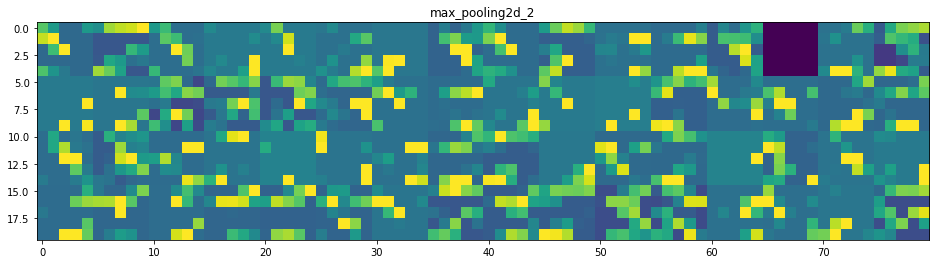

In [24]:
layer_names = []
for layer in model.layers:
    layer_names.append(layer.name) # Names of the layers, so you can have them as part of your plot
    
images_per_row = 16

for layer_name, layer_activation in zip(layer_names, activations): # Displays the feature maps
    n_features = layer_activation.shape[-1] # Number of features in the feature map/number of filters 32,32,64,64
    size = layer_activation.shape[1] #The feature map has shape (1, size, size, n_features). the height of the image
    n_cols = n_features // images_per_row # Tiles the activation channels in this matrix
    display_grid = np.zeros((size * n_cols, images_per_row * size))
    for col in range(n_cols): # Tiles each filter into a big horizontal grid
        for row in range(images_per_row):
            channel_image = layer_activation[0,
                                             :, :,
                                             col * images_per_row + row] #The output of each filter
            channel_image -= channel_image.mean() # Post-processes the feature to make it visually palatable
            channel_image /= channel_image.std() #standardize the pixels
            channel_image *= 64
            channel_image += 128
            channel_image = np.clip(channel_image, 0, 255).astype('uint8')
            display_grid[col * size : (col + 1) * size, # Displays the grid
                         row * size : (row + 1) * size] = channel_image
    scale = 1. / size
    plt.figure(figsize=(scale * display_grid.shape[1],
                        scale * display_grid.shape[0]))
    plt.title(layer_name)
    plt.grid(False)
    plt.imshow(display_grid, aspect='auto', cmap='viridis')

__Exercise 1__ In the above model we selected a sequence of convolutions, pooling, dropouts, and dense layers.  Run the following experiments with 4 epochs and 32 minibatch size, each time reporting the accuracy.

- Remove dropout layers.
- Remove first max pooling layer, does it take longer or shorter to train?
- Try sigmoid activation functions instead of ReLU.

__Model 1: Remove Dropout Layers__

<font color=blue>
    The test loss is 0.02619979902961277 and the test accuracy is 0.9917.
    
   The accuracy becomes higher when removing dropout layers.
   </font>
   
__Model 2: Remove First Max Pooling Layer__

<Font color=blue>
    The test loss is 0.036217603227387374 and the test accuracy is 0.9878.
    
   When removing the first max pooling layer, the training time triples. So it takes longer time to train.
   
   </font>


__Model 3: Sigmoid Activation Function__

<font color=blue>
    The test loss is 0.08509192908015102 and the test accuracy is 0.9723.
    
   The accuracy using sigmoid activation function is a little smaller than the accuracy of ReLU.
   </font>


In [44]:
batch_size = 32
num_classes = 10
epochs = 4

# input image dimensions
img_rows, img_cols = 28, 28

In [45]:
# the data, split between train and test sets
(x_train, y_train), (x_test, y_test) = datasets.mnist.load_data()
# MNIST dataset contains greyscale 10 digit imges, with 60000 train samples and 10000 test samples
if K.image_data_format() == 'channels_first':
    x_train = x_train.reshape(x_train.shape[0], 1, img_rows, img_cols) # 4 dimension tensor, 1 represents there is only 1 channel.
    x_test = x_test.reshape(x_test.shape[0], 1, img_rows, img_cols)
    input_shape = (1, img_rows, img_cols)
else:
    x_train = x_train.reshape(x_train.shape[0], img_rows, img_cols, 1)
    x_test = x_test.reshape(x_test.shape[0], img_rows, img_cols, 1)
    input_shape = (img_rows, img_cols, 1)

In [46]:
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255
print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

x_train shape: (60000, 28, 28, 1)
60000 train samples
10000 test samples


In [47]:
# convert class vectors to binary class matrices
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

In [23]:
model1 = keras.Sequential()
model1.add(layers.Conv2D(32, kernel_size=(3, 3),
                 activation='relu',
                 input_shape=input_shape))

model1.add(layers.MaxPooling2D(pool_size=(2, 2))) # the output should be 13*13, with 32 filter?
#Pooling can be max or average, here we use max
model1.add(layers.Conv2D(64, (3, 3), activation='relu'))
model1.add(layers.MaxPooling2D(pool_size=(2, 2)))

#model.add(layers.Dropout(0.25))
model1.add(layers.Flatten())
model1.add(layers.Dense(128, activation='relu'))
model1.add(layers.Dense(num_classes, activation='softmax'))

In [24]:
for l in model1.layers:
    print("{} : {} to {}".format(l.name,l.input_shape,l.output_shape))

conv2d_3 : (None, 28, 28, 1) to (None, 26, 26, 32)
max_pooling2d_3 : (None, 26, 26, 32) to (None, 13, 13, 32)
conv2d_4 : (None, 13, 13, 32) to (None, 11, 11, 64)
max_pooling2d_4 : (None, 11, 11, 64) to (None, 5, 5, 64)
flatten_2 : (None, 5, 5, 64) to (None, 1600)
dense_6 : (None, 1600) to (None, 128)
dense_7 : (None, 128) to (None, 10)


In [25]:
model1.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.Adadelta(),
              metrics=['accuracy'])

model1.fit(x_train, y_train,
          batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          validation_data=(x_test, y_test))
score1 = model1.evaluate(x_test, y_test, verbose=0)
print('Test loss:', score1[0])
print('Test accuracy:', score1[1])

Train on 60000 samples, validate on 10000 samples
Epoch 1/4
60000/60000 [==============================] - 34s 570us/step - loss: 0.1240 - acc: 0.9613 - val_loss: 0.0416 - val_acc: 0.9862
Epoch 2/4
60000/60000 [==============================] - 34s 566us/step - loss: 0.0394 - acc: 0.9880 - val_loss: 0.0270 - val_acc: 0.9906
Epoch 3/4
60000/60000 [==============================] - 36s 597us/step - loss: 0.0278 - acc: 0.9917 - val_loss: 0.0260 - val_acc: 0.9910
Epoch 4/4
60000/60000 [==============================] - 34s 570us/step - loss: 0.0209 - acc: 0.9935 - val_loss: 0.0262 - val_acc: 0.9917
Test loss: 0.02619979902961277
Test accuracy: 0.9917


In [26]:
model2 = keras.Sequential()
model2.add(layers.Conv2D(32, kernel_size=(3, 3),
                 activation='relu',
                 input_shape=input_shape))

#model2.add(layers.MaxPooling2D(pool_size=(2, 2)))

model2.add(layers.Conv2D(64, (3, 3), activation='relu'))
model2.add(layers.MaxPooling2D(pool_size=(2, 2)))

model2.add(layers.Dropout(0.25))
model2.add(layers.Flatten())
model2.add(layers.Dense(128, activation='relu'))
model2.add(layers.Dropout(0.5))
model2.add(layers.Dense(num_classes, activation='softmax'))

In [27]:
for l in model2.layers:
    print("{} : {} to {}".format(l.name,l.input_shape,l.output_shape))

conv2d_5 : (None, 28, 28, 1) to (None, 26, 26, 32)
conv2d_6 : (None, 26, 26, 32) to (None, 24, 24, 64)
max_pooling2d_5 : (None, 24, 24, 64) to (None, 12, 12, 64)
dropout_2 : (None, 12, 12, 64) to (None, 12, 12, 64)
flatten_3 : (None, 12, 12, 64) to (None, 9216)
dense_8 : (None, 9216) to (None, 128)
dropout_3 : (None, 128) to (None, 128)
dense_9 : (None, 128) to (None, 10)


In [29]:
model2.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.Adadelta(),
              metrics=['accuracy'])

model2.fit(x_train, y_train,
          batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          validation_data=(x_test, y_test))
score2 = model2.evaluate(x_test, y_test, verbose=0)
print('Test loss:', score2[0])
print('Test accuracy:', score2[1])

Train on 60000 samples, validate on 10000 samples
Epoch 1/4
60000/60000 [==============================] - 126s 2ms/step - loss: 0.1248 - acc: 0.9630 - val_loss: 0.0443 - val_acc: 0.9858
Epoch 2/4
60000/60000 [==============================] - 121s 2ms/step - loss: 0.0736 - acc: 0.9785 - val_loss: 0.0406 - val_acc: 0.9857
Epoch 3/4
60000/60000 [==============================] - 126s 2ms/step - loss: 0.0611 - acc: 0.9823 - val_loss: 0.0324 - val_acc: 0.9886
Epoch 4/4
60000/60000 [==============================] - 133s 2ms/step - loss: 0.0523 - acc: 0.9844 - val_loss: 0.0362 - val_acc: 0.9878
Test loss: 0.036217603227387374
Test accuracy: 0.9878


In [48]:
model3 = keras.Sequential()
model3.add(layers.Conv2D(32, kernel_size=(3, 3),
                 activation='sigmoid',
                 input_shape=input_shape))

model3.add(layers.MaxPooling2D(pool_size=(2, 2)))

model3.add(layers.Conv2D(64, (3, 3), activation='sigmoid'))
model3.add(layers.MaxPooling2D(pool_size=(2, 2)))

model3.add(layers.Dropout(0.25))
model3.add(layers.Flatten())
model3.add(layers.Dense(128, activation='sigmoid'))
model3.add(layers.Dropout(0.5))
model3.add(layers.Dense(num_classes, activation='softmax'))

In [49]:
for l in model3.layers:
    print("{} : {} to {}".format(l.name,l.input_shape,l.output_shape))

conv2d_13 : (None, 28, 28, 1) to (None, 26, 26, 32)
max_pooling2d_12 : (None, 26, 26, 32) to (None, 13, 13, 32)
conv2d_14 : (None, 13, 13, 32) to (None, 11, 11, 64)
max_pooling2d_13 : (None, 11, 11, 64) to (None, 5, 5, 64)
dropout_10 : (None, 5, 5, 64) to (None, 5, 5, 64)
flatten_7 : (None, 5, 5, 64) to (None, 1600)
dense_16 : (None, 1600) to (None, 128)
dropout_11 : (None, 128) to (None, 128)
dense_17 : (None, 128) to (None, 10)


In [50]:
model3.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.Adadelta(),
              metrics=['accuracy'])

model3.fit(x_train, y_train,
          batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          validation_data=(x_test, y_test))
# Verbosity mode. 0 = silent, 1 = progress bar, 2 = one line per epoch.
# Data on which to evaluate the loss and any model metrics at the end of each epoch.
#     The model will not be trained on validation_data.
score3 = model3.evaluate(x_test, y_test, verbose=0)
print('Test loss:', score3[0])
print('Test accuracy:', score3[1])

Train on 60000 samples, validate on 10000 samples
Epoch 1/4
60000/60000 [==============================] - 40s 661us/step - loss: 2.3054 - acc: 0.1111 - val_loss: 2.3003 - val_acc: 0.1135
Epoch 2/4
60000/60000 [==============================] - 36s 607us/step - loss: 1.0438 - acc: 0.6265 - val_loss: 0.1801 - val_acc: 0.9470
Epoch 3/4
60000/60000 [==============================] - 36s 607us/step - loss: 0.2145 - acc: 0.9346 - val_loss: 0.0990 - val_acc: 0.9692
Epoch 4/4
60000/60000 [==============================] - 39s 656us/step - loss: 0.1539 - acc: 0.9534 - val_loss: 0.0851 - val_acc: 0.9723
Test loss: 0.08509192908015102
Test accuracy: 0.9723
